### Load Data, extract text corpus and target

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../input/train.csv")
# df = df[:10000] # for Testing purposes
num_samples,n = df.shape
print(num_samples, n)

X = df.loc[:, 'question_text'].values
y = df.loc[:, 'target'].values

print("Type train X", type(X))
print("Type target y: ", type(y))

1306122 3
Type train X <class 'numpy.ndarray'>
Type target y:  <class 'numpy.ndarray'>


In [2]:
X[0] # First Question in dataset

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [3]:
y[0] # classification of first sentence. 0 means NOT insincere

0

**Preprocessing Function**

* lower case everything
* remove punctuation and stopwords

In [4]:
import re
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def my_preprocessor(text):
        ## Iterate over the data to preprocess by removing stopwords
        lines_without_stopwords=[] 
        for line in text: 
            line = line.lower()
            line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE)
              #  # remove punctuation ans split
            new_line=[]
            for word in line_by_words:
                if word not in stop:
                    new_line.append(word)
            lines_without_stopwords.append(new_line)
        texts = lines_without_stopwords
        return texts

In [5]:
my_preprocessor(X[[0]])

[['quebec', 'nationalists', 'see', 'province', 'nation', '1960s']]

### Tokenisation with Keras Tokenizer Class

-  https://keras.io/preprocessing/text/

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # max seuquence length (max 100 words of each question is used)
max_words = 10000 # only 10k most frequent are used to create the vocabulary

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) 
  # fit method creates vocabulary index based on word frequency
  # each found word gets unique integer e.g. {how: 1, the: 2, ...}
sequences = tokenizer.texts_to_sequences(X)
  # texts_to_sequences method converts a text to a sequence of words (or tokens)
print("First Sentence sequenced: ", sequences[0])
word_index = tokenizer.word_index
  # contains vocabulary
print("First word ""how"" within word-index.dictionary: ", word_index.get("how"))
print("{} unique Tokens within word_index dict." .format(len(word_index)))

# shorten/fill sequences to maxlen
data = pad_sequences(sequences, maxlen=maxlen) 

Using TensorFlow backend.


First Sentence sequenced:  [9, 48, 6683, 7219, 158, 55, 6107, 36, 4, 1206, 6, 1, 8333]
First word how within word-index.dictionary:  9
222161 unique Tokens within word_index dict.


**Split validation & Transformation of target**

In [7]:

training_samples = int(num_samples * 0.8)
print("Number used training_samples: ", training_samples)
# validation_samples = num_samples * 0.2

# Transformation target labels to 
labels = np.asarray(y)
print('Shape data tensors:', data.shape) # 10k samples, each sequene equal length 100 
print('Shape target tensors:', labels.shape) # 1D Tensor

# Mixing data to ensure both train and validation set contain both classes
# (stratifed sampling better method - maybe later)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)  # Mixing
data = data[indices]
labels = labels[indices]

# Erstelung Validation set
x_train = data[:training_samples] 
y_train = labels[:training_samples]
x_val = data[training_samples:]
y_val = labels[training_samples:]

Number used training_samples:  1044897
Shape data tensors: (1306122, 100)
Shape target tensors: (1306122,)


In [8]:
# Exemplary look at the new (because shuffled) first sequence in train set
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  15,   8, 952, 218,  57], dtype=int32)

### Preprocessing glove embeddings

In [9]:
embeddings_dict = {} # create empty embedding dictionary
# Open glove file (vector size 300!)
embedding_file = open('../input/embeddings/glove.840B.300d/glove.840B.300d.txt')

# Fill embedding dict with word: vector(coefs) pairs
for line in embedding_file:
    line_values = line.split(' ') # read in values of respective line (= vector)
    word = line_values[0] #  # first value in line represents the word
    coefs = np.asarray(line_values[1:], dtype='float32') 
      # # all other values in line represent the word vector
    embeddings_dict[word] = coefs # add key(word), value(vector) pairs to dict

embedding_file.close() 
print('Embedding loaded')
print('{} word vectors within embeddings_dict.'.format(len(embeddings_dict)))
 

Embedding loaded
2196016 word vectors within embeddings_dict.


**Creation Embedding Matrix**

* embeddings_dict now contains about 2.2 million words with corresponding vector representation
* However not all these word: vector pairs are needed
* A word representation from the embedding only has to be found for the most frequent 10.000 word within the text corpus (= the questions)
* These 10k words already are contained within word_index dict which was created earlier
* In the following code a embedding matrix is created for the 10k words

In [10]:
embedding_dim = 300 # (vector size 300!)
# Creation empty matrix
embedding_matrix = np.zeros((max_words, embedding_dim))

# Filling up matrix
for word, i in word_index.items(): 
        # in index data is stored: {word:index, word_index, ..}
    if i < max_words: # only use 10k most frequent words
        embedding_vector = embeddings_dict.get(word) 
          # get vector for word from embedding
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
              # implies that word that are not found get zero vector
                
print('Embeddings_matrix created')
print('Shape embedding_matrix: {}'.format(embedding_matrix.shape))


Embeddings_matrix created
Shape embedding_matrix: (10000, 300)


In [11]:
# Having a look at the first two lines within the created matrix:

# embedding_matrix[0] # Why is this vector zero?
# embedding_matrix[1] # Why does this vector contain coefs?

print("First two words in word_index: {} " .format(list(word_index.items())[0:2])) 

# Explanation: The Word_index starts at 1, not at 0
# This means the first i returned in the above loop through word index is 1
# embedding_matrix[0] never is touched - stays zero
# embedding_matrix[1] is the first row that is filled with coefs

First two words in word_index: [('the', 1), ('what', 2)] 


**Memory management**

* The embeddings_dict consumes much RAM but is not needed anymore. 

In [12]:
del embeddings_dict
import gc; 
collected = gc.collect() 
print("Garbage collector: collected {} objects.".format((collected))) 

Garbage collector: collected 0 objects.


### Definition Keras Model

-  Input for model are batches of sequences
   -  Input shape: 2D tensor(matrix): (batch_size, sequence_length). 
-  each sequence has a maximum length of maxlen (here: 100)
-  Embedding Layer translates Integers of each sequence into dense vectors    
  (comp. https://keras.io/layers/embeddings/)
   -  input_length: Length of input sequence
-  embedding_matrix translates integers into into 3D Tensores of shape:
   - Output shape: (batch_size, sequence_length, output_dim) 

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dropout, Conv1D, MaxPooling1D, LSTM
model = Sequential()
model.add(Embedding(input_dim = max_words, # 10k different words/integers
                    output_dim = embedding_dim, # Vector 300
                    input_length = maxlen)) # seqeuence length 100

# after the first layer, size of the input must not be specified anymore:
# https://keras.io/layers/core/

#model.add(Flatten()) # reduction 3D tensor(embedding output) to 2D tensor: 
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
# model.add(Dense(32, activation='relu')) # implements the operation: output = activation(dot(input, kernel) + bias)
# output array of shape (*, 32)
model.add(Dense(1, activation='sigmoid')) # final -  binary classifier

# Weights of embedding layer shall nt be trainable because doing so
# one would lose the benefit of using pretrained embeddings
# Created embedding matrix is set as weights for embedding layer
model.layers[0].set_weights([embedding_matrix]) 
# Setting weights not trainable 
model.layers[0].trainable = False 

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)      

### Training Model

In [14]:
model.compile(optimizer='adam', # rmsprop bad results
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training process is logged in history object for visualition purposes
history = model.fit(x_train, y_train,
                    epochs = 1, # optimal number of epochs?
                    batch_size= 32, # optimal batch size ?
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
 347360/1044897 [========>.....................] - ETA: 14:22 - loss: 0.1290 - acc: 0.9504

### Evaluation Modell

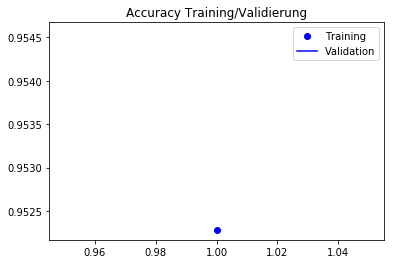

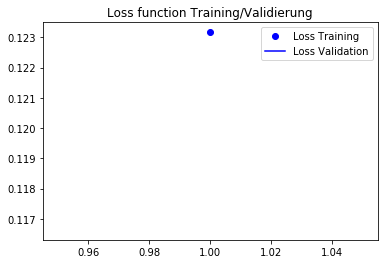

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy Training/Validierung')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validation')
plt.title('Loss function Training/Validierung')
plt.legend()
plt.show()

**Prediction and Submission**

In [16]:
# Load test file
test = pd.read_csv("../input/test.csv")
# test = test[:10] # for Testing purposes
X_test = test.loc[:, 'question_text'].values

# Preprocessing
X_test = my_preprocessor(X_test)

# Transformation question to Integer sequence
sequences = tokenizer.texts_to_sequences(X_test) # text to int
data = pad_sequences(sequences, maxlen=maxlen) # padding to length 100

# My predictions
predictions = model.predict(data, batch_size = 32, verbose = 1)

# Create a submission dataframe and append relevant columns
submission = pd.DataFrame()
submission['qid'] = test['qid'].values
submission['prediction'] = np.round(predictions).astype(int) # round sigmoid results to integers

# Do test and my submission Dataframe have the same length?
if len(submission) == len(test):
    print("Submission dataframe has the same length as test dataframe with shape:{}".format(submission.shape))
else:
    print("Something is wrong!")
    
submission.head()

375806/375806 [==============================] - 158s 421us/step
Submission dataframe has the same length as test dataframe with shape:(375806, 2)


,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [17]:
# Submission as Output
submission.to_csv('submission.csv', index = False)